In [ ]:
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt

In [ ]:
def gate_kq_NN_func(params, X, gamma=1.0):

  W, Wk, Wq, Wv, Wout = params

  #W, Wk, Wq, Wout = params


  D = X.shape[0]
  N = W.shape[1] # W is G x N x D
  print(W.shape[1])
  G = W.shape[0]


  # Wk, Wq are G x N x D
  # Wout is N x G

  # read in operation, one vector per gate
  h = 1.0 / jnp.sqrt(D) * jnp.einsum('ijk,kl->ijl' , W , X) # G x N x P
  #h = h * (h > 0.0)

  # G keys
  k = 1.0 / jnp.sqrt(D) * jnp.einsum('ijk,kl->ijl',  Wk , X) # G x N x P

  # G queries
  q = 1.0 / jnp.sqrt(D) * jnp.einsum('ijk,kl->ijl',  Wq , X) # G x N x P

  A = 1.0/ N * jnp.einsum('ijk,ijk->ik', k, q) # G x P
  v = 1.0/jnp.sqrt(D) * jnp.einsum('ijk,kl->ijl',  Wv , X) # G x N x P

  # softmax nonlinearity
  phi_A = A * ( A > 0.0 ) # G x P

  out = jnp.einsum('ik,ilk->ilk', phi_A, v) # G x N x P
  f = jnp.einsum('ijk,ij->k', out, Wout) / jnp.sqrt(G) / N / gamma
  return f

def single_int_gate_NN_func(params, X, gamma=1.0, alpha = 1.0):

  W, Vk, Wq, Wv, Wout = params

  # Vk is G x N
  # Wout

  D = X.shape[0]
  N = W.shape[1] # W is G x N x D
  print(W.shape[1])
  G = W.shape[0]

  # Wk, Wq are G x N x D
  # Wout is N x G

  # read in operation, one vector per gate
  h = 1.0 / jnp.sqrt(D) * jnp.einsum('ijk,kl->ijl' , W , X) # G x N x P
  #h = h * (h > 0.0)

  # G keys
  q = 1.0 / jnp.sqrt(D) * N**(alpha-1.0) *  jnp.einsum('ijk,kl->ijl',  Wq , X) # G x N x P

  # G queries
  k = N**(alpha - 1.0) * Vk
  A = 1.0/ N**(alpha) * jnp.einsum('ijk,ij->ik', q, k) # G x P
  v = 1.0 / jnp.sqrt(D) * jnp.einsum('ijk,kl->ijl',  Wv , X) # G x N x P

  # relu like nonlinearity
  #phi_A = A * (A > 0.0) # G x P
  phi_A = jnp.exp( A )

  out = jnp.einsum('ik,ijk->ijk', phi_A, v) # G x N x P
  f = jnp.einsum('ijk,ij->k', out, Wout) / N / gamma
  return f


def single_int_gate_NN_get_gate(params, X, gamma=1.0, alpha = 1.0):

  W, Vk, Wq, Wv, Wout = params

  # Vk is G x N
  # Wout

  D = X.shape[0]
  N = W.shape[1] # W is G x N x D
  print(W.shape[1])
  G = W.shape[0]

  # Wk, Wq are G x N x D
  # Wout is N x G

  # read in operation, one vector per gate
  h = 1.0 / jnp.sqrt(D) * jnp.einsum('ijk,kl->ijl' , W , X) # G x N x P
  #h = h * (h > 0.0)

  # G keys
  q = 1.0 / jnp.sqrt(D) * N**(alpha-1.0) *  jnp.einsum('ijk,kl->ijl',  Wq , X) # G x N x P

  # G queries
  k = N**(alpha - 1.0) * Vk
  A = 1.0/ N**(alpha) * jnp.einsum('ijk,ij->ik', q, k) # G x P
  return A



def train_model(X, y, N, G, T, eta, gamma, alpha = 1.0, warm = True):

  D = X.shape[0]

  params = [random.normal(random.PRNGKey(0), (G,N,D))] # W
  params += [ random.normal(random.PRNGKey(1), (G,N)) * N**(1.0 - alpha) ] # Vk


  rho_vals = jnp.zeros(G)

  if warm:
    rho_vals = jnp.linspace(-0.9, 0.9, G)
    #rho_vals = jnp.ones(G)

  sqrt_rho = jnp.sqrt( 1 - rho_vals**2 )

  #Wq = N**(alpha - 1.0) * rho_vals[:,jnp.newaxis,jnp.newaxis]  * jnp.einsum('ij,k->ijk', params[-1], random.normal(random.PRNGKey(3), (D,)))
  Wq = N**(alpha - 1.0) * rho_vals[:,jnp.newaxis,jnp.newaxis]  * jnp.einsum('ij,ik->ijk', params[-1], random.normal(random.PRNGKey(3), (G,D)))
  Wq += N**(1.0 - alpha) *  sqrt_rho[:,jnp.newaxis,jnp.newaxis] * random.normal(random.PRNGKey(4), (G,N,D))


  params += [ Wq ] # G x N x D
  params += [ random.normal(random.PRNGKey(5), (G,N,D)) ] # G x N x D
  params += [ random.normal(random.PRNGKey(6), (G,N)) ] # G x N

  opt_init, opt_update, get_params = optimizers.sgd(0.5 * N * gamma**2 * eta)

  loss_fn = jit( lambda p, X, y: jnp.mean( (single_int_gate_NN_func(p, X, gamma, alpha) - single_int_gate_NN_func(params, X, gamma, alpha)  - y)**2) )
  grad_fn = jit( grad(loss_fn))
  opt_state = opt_init(params)

  A0 =  single_int_gate_NN_get_gate(params, X, gamma, alpha)

  losses = []
  for t in range(T):
    opt_state = opt_update(t, grad_fn(get_params(opt_state), X, y), opt_state)
    losses += [loss_fn(get_params(opt_state), X, y)]

  Af = single_int_gate_NN_get_gate(get_params(opt_state), X, gamma, alpha)

  print(f"A0 : {jnp.mean(A0**2)}")
  print(f"A-A0: {jnp.mean((A0 - Af)**2)}")
  return losses, A0, Af



def train_kq_model(X, y, N, G, T, eta, gamma):

  D = X.shape[0]

  params = [random.normal(random.PRNGKey(0), (G,N,D))] # W
  params += [ random.normal(random.PRNGKey(1), (G,N,D)) ] # Wk

  rho_vals = jnp.linspace(-0.99, 0.99, G)
  #rho_vals = 2.0*random.uniform(random.PRNGKey(1), (G,) )-1.0
  sqrt_rho = jnp.sqrt( 1 - rho_vals**2 )

  Wq = rho_vals[:,jnp.newaxis,jnp.newaxis]  * params[-1]
  Wq += sqrt_rho[:,jnp.newaxis,jnp.newaxis] * random.normal(random.PRNGKey(4), (G,N,D))


  params += [ Wq ] # G x N x D
  params += [ random.normal(random.PRNGKey(5), (G,N,D)) ] # G x N x D
  params += [ random.normal(random.PRNGKey(6), (G,N)) ] # G x N

  opt_init, opt_update, get_params = optimizers.sgd(0.5 * N * gamma**2 * eta)

  loss_fn = jit( lambda p, X, y: jnp.mean( (gate_kq_NN_func(p, X, gamma) - gate_kq_NN_func(params, X, gamma)  - y)**2) )
  grad_fn = jit( grad(loss_fn))
  opt_state = opt_init(params)

  losses = []
  for t in range(T):
    opt_state = opt_update(t, grad_fn(get_params(opt_state), X, y), opt_state)
    losses += [loss_fn(get_params(opt_state), X, y)]

  return losses


(2, 4)


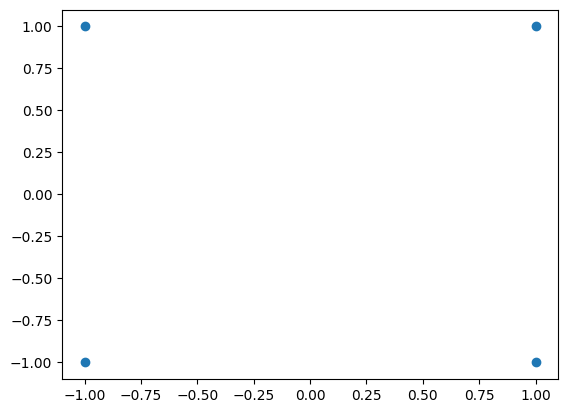

In [ ]:
# XOR problem

X = jnp.array([[ 1.0,1.0 ], [1.0,-1.0], [-1.0,-1.0], [-1.0,1.0] ]).T
print(X.shape)
y = jnp.array([1.0, -1.0, 1.0, -1.0])

plt.scatter(X[0,:], X[1,:])
plt.show()

In [ ]:
eta = 0.1
gamma = 0.25

T = 200

G = 4
Nvals = [100, 250, 500, 1000, 2500, 5000, 8000]
losses = [ train_model(X, y, N, G, T, eta, gamma, alpha = 0.5, warm = True) for N in Nvals]
print(len(losses[0]))

100
100
100
100
A0 : 1.6881277561187744
A-A0: 0.014490009285509586
250
250
250
250
A0 : 1.129249930381775
A-A0: 0.0001254931412404403
500
500
500
500
A0 : 0.5221683979034424
A-A0: 0.011319009587168694
1000
1000
1000
1000
A0 : 1.2404192686080933
A-A0: 0.00014408814604394138
2500
2500
2500
2500
A0 : 0.42397576570510864
A-A0: 0.0011572021758183837
5000
5000
5000
5000
A0 : 0.5348619818687439
A-A0: 0.00047197419917210937
8000
8000
8000
8000
A0 : 1.4141820669174194
A-A0: 0.0003147230891045183
200


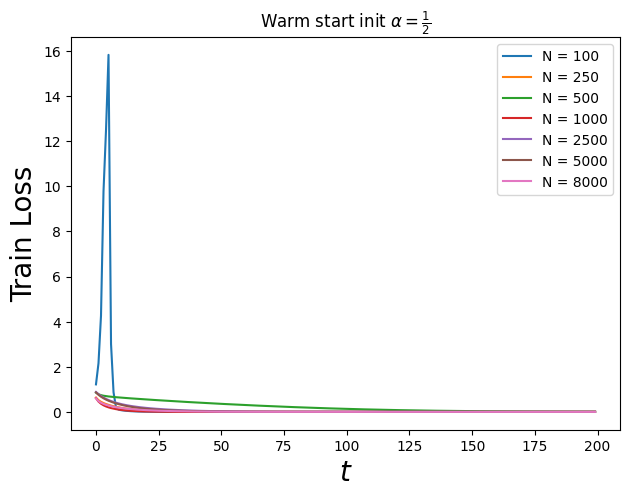

In [ ]:
for i, loss in enumerate(losses):
  plt.plot(loss, label = 'N = %d' % Nvals[i])
plt.legend()
plt.ylabel(r'Train Loss',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.tight_layout()
plt.title(r'Warm start init $\alpha = \frac{1}{2}$')
plt.show()

In [ ]:
eta = 0.1
gamma = 0.25

T = 200

G = 8
Nvals = [100, 250, 500, 1000, 2500, 5000, 8000]
losses = [ train_model(X, y, N, G, T, eta, gamma, alpha = 1.0, warm = True) for N in Nvals]
print(len(losses[0]))

100
100
100
100
A0 : 0.27226123213768005
A-A0: 0.0092757074162364
250
250
250
250
A0 : 0.2520407438278198
A-A0: 0.006555998232215643
500
500
500
500
A0 : 0.23176290094852448
A-A0: 0.004917721264064312
1000
1000
1000
1000
A0 : 0.2232833057641983
A-A0: 0.005081996787339449
2500
2500
2500
2500
A0 : 0.2415909618139267
A-A0: 0.005174862686544657
5000
5000
5000
5000
A0 : 0.24029020965099335
A-A0: 0.005567260552197695
8000
8000
8000
8000
A0 : 0.23581205308437347
A-A0: 0.0048815119080245495
200


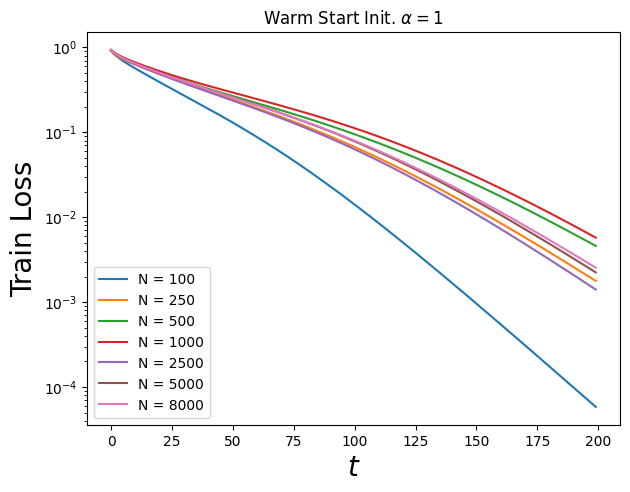

In [ ]:
for i, loss in enumerate(losses):
  plt.semilogy(loss, label = 'N = %d' % Nvals[i])
plt.legend()
plt.ylabel(r'Train Loss',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.tight_layout()
plt.title(r'Warm Start Init. $\alpha = 1$')
plt.show()

In [ ]:
eta = 0.1
gamma = 0.01

T = 200

G = 8
Nvals = [100, 250, 500, 1000, 2500, 5000, 8000]
losses = [ train_model(X, y, N, G, T, eta, gamma, alpha = 0.5, warm = False) for N in Nvals]
print(len(losses[0]))

100
100
100
100
A0 : 1.152495265007019
A-A0: 6.281861146817391e-07
250
250
250
250
A0 : 0.4672347903251648
A-A0: 3.918507331945875e-07
500
500
500
500
A0 : 1.0610982179641724
A-A0: 2.4413967736336417e-08
1000
1000
1000
1000
A0 : 1.5377109050750732
A-A0: 0.0001702214067336172
2500
2500
2500
2500
A0 : 0.6834596395492554
A-A0: 4.682747967166279e-09
5000
5000
5000
5000
A0 : 0.6380332708358765
A-A0: 4.319670843244694e-09
8000
8000
8000
8000
A0 : 0.802241325378418
A-A0: 8.307504684168521e-10
200


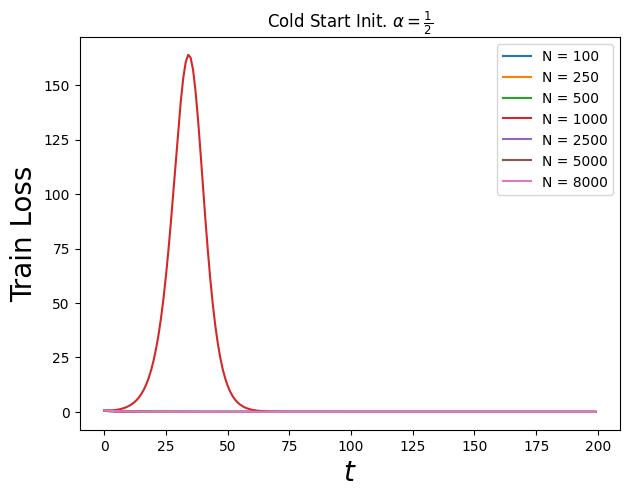

In [ ]:
for i, loss in enumerate(losses):
  plt.plot(loss, label = 'N = %d' % Nvals[i])
plt.legend()
plt.ylabel(r'Train Loss',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.tight_layout()
plt.title(r'Cold Start Init. $\alpha = \frac{1}{2}$')
plt.show()

In [ ]:
eta = 0.2
gamma = 0.2

T = 200

G = 8
Nvals = [100, 250, 500, 1000, 2500, 5000, 8000, 10000]
losses = [ train_model(X, y, N, G, T, eta, gamma, alpha = 1.0, warm = False) for N in Nvals]
print(len(losses[0]))

100
100
100
100
A0 : 0.011524947360157967
A-A0: 0.03695935755968094
250
250
250
250
A0 : 0.0018689397256821394
A-A0: 0.05075445771217346
500
500
500
500
A0 : 0.0021221956703811884
A-A0: 0.04358336329460144
1000
1000
1000
1000
A0 : 0.0015377115923911333
A-A0: 0.041299425065517426
2500
2500
2500
2500
A0 : 0.00027338392101228237
A-A0: 0.019421763718128204
5000
5000
5000
5000
A0 : 0.00012760664685629308
A-A0: 0.014113430865108967
8000
8000
8000
8000
A0 : 0.00010028012911789119
A-A0: 0.005937827751040459
10000
10000
10000
10000
A0 : 0.0001616109220776707
A-A0: 0.010783364064991474
200


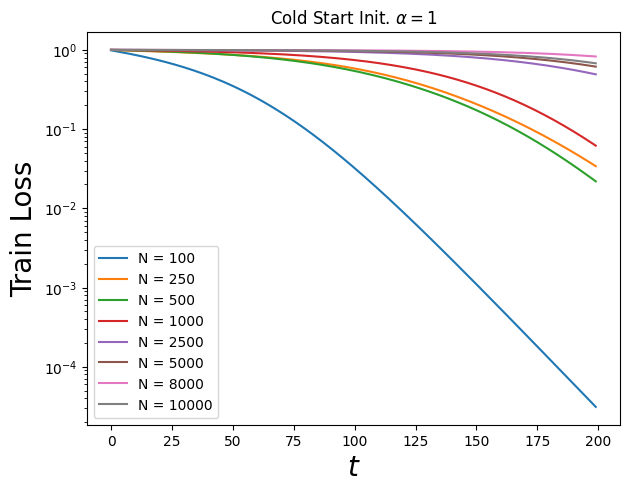

In [ ]:
for i, loss in enumerate(losses):
  plt.semilogy(loss, label = 'N = %d' % Nvals[i])
plt.legend()
plt.ylabel(r'Train Loss',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.tight_layout()
plt.title(r'Cold Start Init. $\alpha = 1$')
plt.show()

In [ ]:
def DMFT_alpha_1(X, y, G, T, eta, gamma):

  D, P = X.shape

  Cx = 1.0 / D * X.T @ X

  # initial alignments
  rho_vals = jnp.linspace(-0.9, 0.9, G)

  # initialize order parameters Q, K, f

  fg = jnp.zeros((G, P)) # < z v > correlator
  Z = jnp.ones(G) # < z^g(t)^2 >

  V = jnp.einsum('i,jk->ijk', jnp.ones(G), Cx) # V^g_{\mu\nu}(0) = C^x_{\mu\nu} , G x P x P
  Q = jnp.einsum('i,jk->ijk', jnp.ones(G), Cx) # G x P x P

  K = jnp.ones(G) # G

  # instead of rho, consider using different vectors u in the outer product k u^T
  # use partial alignments rho

  A =  jnp.einsum('i,ik->ik', rho_vals , random.normal(random.PRNGKey(3), (G,D)) @ X / jnp.sqrt(D) )
  #A = jnp.einsum('i,j->ij', rho_vals , X.T @ random.normal(random.PRNGKey(3), (D,)) ) # G x P

  losses = []
  all_A = []

  for t in range(T):

    NTK_t = V + jnp.einsum('i,jk->ijk', Z, Cx)
    phi_t = jnp.exp( A ) # G x P
    all_A += [ A ]

    NTK_t = jnp.einsum('ijk,ik->ijk', NTK_t, phi_t)

    Delta = 1.0 * y - 1.0 / gamma * jnp.sum( phi_t * fg , axis=0)
    losses += [ jnp.mean( Delta**2 ) ]
    df = eta / P * gamma * jnp.einsum('ijk,k->ij', NTK_t, Delta) # G x P

    # Cx * ( Delta * phi )
    Cx_Delta_phi = jnp.einsum('ik,jk->ij', Delta[jnp.newaxis,:] * phi_t, Cx) # G x P
    dV = eta * gamma / P * ( jnp.einsum('ij,ik->ijk', Cx_Delta_phi, fg) + jnp.einsum('ij,ik->ikj', Cx_Delta_phi, fg) )

    dZ = 2 * eta * gamma / P * jnp.einsum('ij,j->i', fg * phi_t, Delta ) # G

    dot_phi_t = jnp.exp( A ) # nice property of exp
    #dot_phi_t = 1.0 * (A > 0.0) # G x P

    dA = eta*gamma/P * jnp.einsum('ijk,ik->ij', Q +  jnp.einsum('i,jk->ijk', K, Cx) , jnp.einsum('ij,j->ij', fg*dot_phi_t, Delta ) )

    Cx_Delta_dot_phi = jnp.einsum('ik,jk->ij', fg * Delta[jnp.newaxis,:] * dot_phi_t, Cx) # G x P

    dQ = eta * gamma / P * ( jnp.einsum('ij,ik->ijk', Cx_Delta_dot_phi, A) + jnp.einsum('ij,ik->ikj', Cx_Delta_dot_phi, A) ) # G x P

    dK = 2 * eta * gamma / P * jnp.einsum('ij,j->i', A * dot_phi_t * fg, Delta ) # G

    """
    dA = jnp.zeros(A.shape)
    dQ = jnp.zeros(Q.shape)
    dK = jnp.zeros(K.shape)
    """

    fg = fg + df
    Z = Z + dZ
    V = V + dV
    Q = Q + dQ
    K = K + dK
    A = A + dA


  return losses, all_A

In [ ]:
eta = 0.002
gamma = 2.5

T = 1000
G = 6
Nvals = [100, 250, 500, 1000, 2500, 5000, 8000, 10000, 20000]
losses = [ train_model(X, y, N, G, T, eta, gamma, alpha = 1.0, warm = True)[0] for N in Nvals]
print(len(losses[0]))

100
100
100
100
A0 : 0.5023247003555298
A-A0: 0.12107723206281662
250
250
250
250
A0 : 0.33559417724609375
A-A0: 0.12862274050712585
500
500
500
500
A0 : 0.3232797086238861
A-A0: 0.12088488042354584
1000
1000
1000
1000
A0 : 0.3267391324043274
A-A0: 0.12825925648212433
2500
2500
2500
2500
A0 : 0.32881495356559753
A-A0: 0.12564876675605774
5000
5000
5000
5000
A0 : 0.3443579375743866
A-A0: 0.12309908121824265
8000
8000
8000
8000
A0 : 0.34051674604415894
A-A0: 0.1252702921628952
10000
10000
10000
10000
A0 : 0.33689209818840027
A-A0: 0.12776468694210052
20000
20000
20000
20000
A0 : 0.34388467669487
A-A0: 0.12623438239097595
1000


In [ ]:
loss_th, all_A = DMFT_alpha_1(X, y, G, T, eta, gamma)

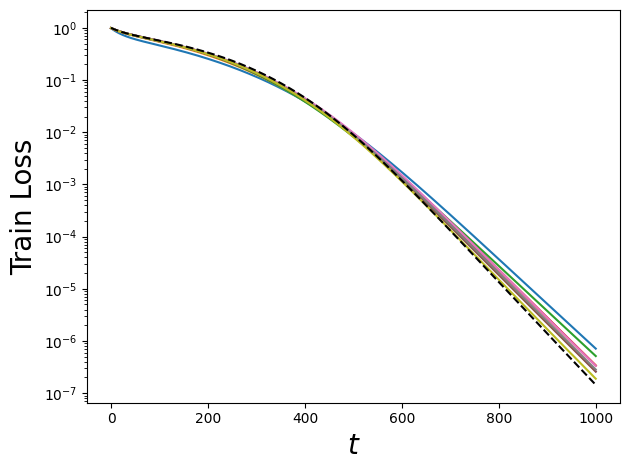

In [ ]:
for loss in losses:
  plt.semilogy(loss)
plt.semilogy(loss_th, '--', color = 'black')
plt.ylabel(r'Train Loss',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.tight_layout()
#plt.ylim([0,3.0])
plt.show()

In [ ]:
N = 10000
_, A0, Af = train_model(X, y, N, G, T, eta, gamma, alpha = 1.0, warm = True)

10000
10000
10000
10000
A0 : 0.33689209818840027
A-A0: 0.12776468694210052


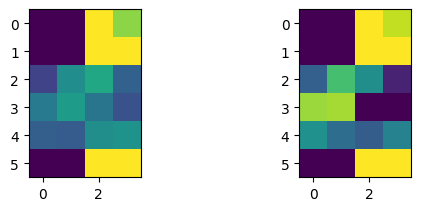

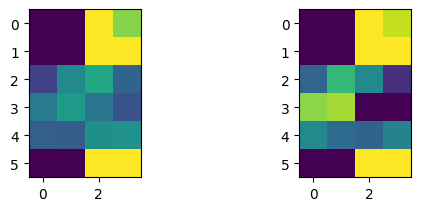

[[-0.28130054 -0.116786    0.28130054  0.116786  ]
 [-0.5825003  -0.6033953   0.5825003   0.6033953 ]
 [ 0.1557985   0.23141947 -0.1557985  -0.23141947]
 [ 0.52285546  0.39989567 -0.52285546 -0.39989567]
 [ 0.22069941  0.07214443 -0.22069941 -0.07214443]
 [-0.311247   -0.27405226  0.311247    0.27405226]]
[[-0.33192217 -0.10513747  0.33192217  0.10513747]
 [-0.39682215 -0.44120538  0.39682215  0.44120538]
 [ 0.12982348  0.2690509  -0.12982348 -0.2690509 ]
 [ 0.5465897   0.39831847 -0.5465897  -0.39831847]
 [ 0.25165775  0.08377677 -0.25165775 -0.08377677]
 [-0.30691928 -0.26083     0.30691928  0.26083   ]]


In [ ]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(all_A[0], vmin = -0.5, vmax = 0.75)
plt.subplot(2,2,2)

plt.imshow(all_A[-1],vmin = -0.5, vmax = 0.75)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(A0,vmin = -0.5,  vmax = 0.75)
plt.subplot(2,2,2)
plt.imshow(Af,vmin = -0.5,  vmax = 0.75)
plt.show()

print(Af-A0)
print(all_A[-1] - all_A[0])